<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20RNN%20Bi-RNN%20timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install torch torchvision matplotlib seaborn plotly graphviz --quiet

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from graphviz import Digraph

In [3]:

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # Forward pass through RNN
        rnn_out, hidden = self.rnn(x, hidden)

        # Apply output layer to all time steps
        output = self.fc(rnn_out)

        return output, hidden

# Define the Bidirectional RNN model
class BidirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BidirectionalRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            batch_first=True,
            bidirectional=True  # This makes it bidirectional
        )

        # Output layer - multiply by 2 because we have forward and backward hidden states
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)

        # Initialize hidden state if not provided
        if hidden is None:
            # For bidirectional RNN, we need 2x the hidden layers (forward and backward)
            hidden = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size)

        # Forward pass through RNN
        rnn_out, hidden = self.rnn(x, hidden)

        # Apply output layer to all time steps
        output = self.fc(rnn_out)

        return output, hidden

# Create sample data for demonstration
def create_sample_data(seq_len=10, batch_size=1, input_size=5):
    # Create a simple pattern: input is a sequence of numbers
    # Output is the cumulative sum of the input sequence
    inputs = torch.randn(batch_size, seq_len, input_size)

    # Create target as cumulative sum of first input dimension
    targets = torch.cumsum(inputs[:, :, 0:1], dim=1)

    return inputs, targets

# Visualization function for RNN structure
def visualize_rnn_structure(input_size, hidden_size, num_layers, bidirectional=False):
    dot = Digraph(comment='RNN Structure', format='png')
    dot.attr(rankdir='TB', size='10,8')

    # Input layer
    dot.node('input', f'Input\n({input_size} features)', shape='box', style='filled', fillcolor='lightblue')

    # Hidden layers
    for i in range(num_layers):
        if bidirectional:
            # Forward layer
            dot.node(f'hidden_f_{i}', f'Forward Layer {i+1}\n({hidden_size} units)', shape='box', style='filled', fillcolor='lightgreen')
            # Backward layer
            dot.node(f'hidden_b_{i}', f'Backward Layer {i+1}\n({hidden_size} units)', shape='box', style='filled', fillcolor='lightcoral')

            # Connect input to both directions
            dot.edge('input', f'hidden_f_{i}')
            dot.edge('input', f'hidden_b_{i}')

            # Add recurrent connections
            dot.edge(f'hidden_f_{i}', f'hidden_f_{i}', label='recurrent (fwd)', style='dashed')
            dot.edge(f'hidden_b_{i}', f'hidden_b_{i}', label='recurrent (bwd)', style='dashed')

            # Connect to next layer if exists
            if i < num_layers - 1:
                dot.edge(f'hidden_f_{i}', f'hidden_f_{i+1}')
                dot.edge(f'hidden_b_{i}', f'hidden_b_{i+1}')
        else:
            dot.node(f'hidden_{i}', f'Hidden Layer {i+1}\n({hidden_size} units)', shape='box', style='filled', fillcolor='lightgreen')
            dot.edge('input', f'hidden_{i}')

            # Add recurrent connection
            dot.edge(f'hidden_{i}', f'hidden_{i}', label='recurrent', style='dashed')

            # Connect to next layer if exists
            if i < num_layers - 1:
                dot.edge(f'hidden_{i}', f'hidden_{i+1}')

    # Output layer
    output_size = hidden_size * 2 if bidirectional else hidden_size
    dot.node('output', f'Output\n(1 feature)', shape='box', style='filled', fillcolor='lightcoral')

    if bidirectional:
        # Connect both directions to output
        dot.edge(f'hidden_f_{num_layers-1}', 'output')
        dot.edge(f'hidden_b_{num_layers-1}', 'output')
    else:
        dot.edge(f'hidden_{num_layers-1}', 'output')

    return dot

# Visualization function for RNN computations over time
def visualize_rnn_computations_over_time(seq_len, input_size, hidden_size, bidirectional=False):
    fig, axes = plt.subplots(2, 2 if bidirectional else 1, figsize=(15, 8))

    # Create a timeline visualization
    time_steps = np.arange(seq_len)

    # Simulate some hidden states over time
    if bidirectional:
        # Create separate forward and backward hidden states
        forward_hidden_states = np.random.randn(seq_len, hidden_size)
        backward_hidden_states = np.random.randn(seq_len, hidden_size)

        # Plot 1: Input features over time
        input_data = np.random.randn(seq_len, input_size)
        im1 = axes[0, 0].imshow(input_data.T, aspect='auto', cmap='viridis')
        axes[0, 0].set_title('Input Features Over Time')
        axes[0, 0].set_xlabel('Time Step')
        axes[0, 0].set_ylabel('Input Feature')
        plt.colorbar(im1, ax=axes[0, 0])

        # Plot 2: Forward hidden states over time
        im2 = axes[0, 1].imshow(forward_hidden_states.T, aspect='auto', cmap='plasma')
        axes[0, 1].set_title('Forward Hidden States Over Time')
        axes[0, 1].set_xlabel('Time Step')
        axes[0, 1].set_ylabel('Hidden Unit')
        plt.colorbar(im2, ax=axes[0, 1])

        # Plot 3: Backward hidden states over time
        im3 = axes[1, 0].imshow(backward_hidden_states.T, aspect='auto', cmap='plasma')
        axes[1, 0].set_title('Backward Hidden States Over Time')
        axes[1, 0].set_xlabel('Time Step')
        axes[1, 0].set_ylabel('Hidden Unit')
        plt.colorbar(im3, ax=axes[1, 0])

        # Plot 4: Combined hidden states over time
        combined_hidden = np.concatenate([forward_hidden_states, backward_hidden_states], axis=1)
        im4 = axes[1, 1].imshow(combined_hidden.T, aspect='auto', cmap='plasma')
        axes[1, 1].set_title('Combined Hidden States (Forward + Backward)')
        axes[1, 1].set_xlabel('Time Step')
        axes[1, 1].set_ylabel('Hidden Unit')
        plt.colorbar(im4, ax=axes[1, 1])
    else:
        # Simulate some hidden states over time
        hidden_states = np.random.randn(seq_len, hidden_size)

        # Plot 1: Input features over time
        input_data = np.random.randn(seq_len, input_size)
        im1 = axes[0].imshow(input_data.T, aspect='auto', cmap='viridis')
        axes[0].set_title('Input Features Over Time')
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Input Feature')
        plt.colorbar(im1, ax=axes[0])

        # Plot 2: Hidden states over time
        im2 = axes[1].imshow(hidden_states.T, aspect='auto', cmap='plasma')
        axes[1].set_title('Hidden States Over Time')
        axes[1].set_xlabel('Time Step')
        axes[1].set_ylabel('Hidden Unit')
        plt.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

# Visualization function for training progress
def plot_training_progress(losses, predictions, targets, bidirectional=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training loss
    axes[0, 0].plot(losses)
    axes[0, 0].set_title('Training Loss Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)

    # Plot 2: Predictions vs Targets
    axes[0, 1].plot(predictions.flatten().detach().numpy(), label='Predictions', marker='o')
    axes[0, 1].plot(targets.flatten().detach().numpy(), label='Targets', marker='s')
    axes[0, 1].set_title('Predictions vs Targets' + (' (Bidirectional)' if bidirectional else ''))
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot 3: Hidden state evolution
    hidden_evolution = torch.randn(len(predictions), 10)  # Simulated hidden states
    im = axes[1, 0].imshow(hidden_evolution.T, aspect='auto', cmap='coolwarm')
    axes[1, 0].set_title('Hidden State Evolution' + (' (Bidirectional)' if bidirectional else ''))
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Hidden Unit')
    plt.colorbar(im, ax=axes[1, 0])

    # Plot 4: Error distribution
    errors = (predictions.flatten() - targets.flatten()).detach().numpy()
    axes[1, 1].hist(errors, bins=20, edgecolor='black')
    axes[1, 1].set_title('Error Distribution' + (' (Bidirectional)' if bidirectional else ''))
    axes[1, 1].set_xlabel('Error')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Visualization function for RNN equations
def visualize_rnn_equations(bidirectional=False):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    if bidirectional:
        ax.text(0.1, 0.8, r'Forward: $h_t^{\leftarrow} = \tanh(W_{ih}^{f} \cdot x_t + b_{ih}^{f} + W_{hh}^{f} \cdot h_{t-1}^{\leftarrow} + b_{hh}^{f})$',
                fontsize=14, transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        ax.text(0.1, 0.7, r'Backward: $h_t^{\rightarrow} = \tanh(W_{ih}^{b} \cdot x_t + b_{ih}^{b} + W_{hh}^{b} \cdot h_{t+1}^{\rightarrow} + b_{hh}^{b})$',
                fontsize=14, transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))
        ax.text(0.1, 0.6, r'Output: $y_t = W_{out} \cdot [h_t^{\leftarrow}; h_t^{\rightarrow}] + b_{out}$',
                fontsize=14, transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    else:
        ax.text(0.1, 0.8, r'$h_t = \tanh(W_{ih} \cdot x_t + b_{ih} + W_{hh} \cdot h_{t-1} + b_{hh})$',
                fontsize=18, transform=ax.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    ax.text(0.1, 0.5 if bidirectional else 0.6, r'Where:', fontsize=14, transform=ax.transAxes)
    ax.text(0.1, 0.4 if bidirectional else 0.5, r'$h_t$ = hidden state at time t', fontsize=12, transform=ax.transAxes)
    ax.text(0.1, 0.3 if bidirectional else 0.4, r'$x_t$ = input at time t', fontsize=12, transform=ax.transAxes)
    ax.text(0.1, 0.2 if bidirectional else 0.3, r'$W_{ih}, W_{hh}$ = weights', fontsize=12, transform=ax.transAxes)
    ax.text(0.1, 0.1 if bidirectional else 0.2, r'$b_{ih}, b_{hh}$ = bias terms', fontsize=12, transform=ax.transAxes)

    if bidirectional:
        ax.text(0.1, 0.0, r'$h_t^{\leftarrow}, h_t^{\rightarrow}$ = forward, backward hidden states', fontsize=12, transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title('RNN Mathematical Representation' + (' (Bidirectional)' if bidirectional else ''), fontsize=16)
    plt.show()

# Visualization function for bidirectional processing
def visualize_bidirectional_processing():
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create sequence
    seq_len = 10
    time_steps = np.arange(seq_len)

    # Forward processing (left to right)
    forward_arrow = ax.annotate('Forward Processing\n(left to right)',
                                xy=(0, 0.5), xytext=(seq_len-1, 0.5),
                                arrowprops=dict(arrowstyle='->', lw=3, color='blue'),
                                fontsize=12, ha='center')

    # Backward processing (right to left)
    backward_arrow = ax.annotate('Backward Processing\n(right to left)',
                                 xy=(seq_len-1, 0.3), xytext=(0, 0.3),
                                 arrowprops=dict(arrowstyle='<-', lw=3, color='red'),
                                 fontsize=12, ha='center')

    # Sequence elements
    for i in range(seq_len):
        ax.text(i, 0.7, f'x{i}', ha='center', va='center', fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

    # Combined hidden states
    for i in range(seq_len):
        ax.text(i, 0.1, f'[h{i}^f; h{i}^b]', ha='center', va='center', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

    ax.set_xlim(-1, seq_len)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Bidirectional RNN Processing: Forward and Backward Passes', fontsize=16)
    plt.show()

In [4]:
print("Recurrent Neural Network (RNN) Demonstration")
print("="*50)

# Define model parameters
input_size = 5
hidden_size = 10
output_size = 1
num_layers = 2
seq_len = 15
batch_size = 1

print(f"Model Parameters:")
print(f"- Input size: {input_size}")
print(f"- Hidden size: {hidden_size}")
print(f"- Output size: {output_size}")
print(f"- Number of layers: {num_layers}")
print(f"- Sequence length: {seq_len}")
print()

# Create the models
model_regular = SimpleRNN(input_size, hidden_size, output_size, num_layers)
model_bidirectional = BidirectionalRNN(input_size, hidden_size, output_size, num_layers)

print("Regular RNN Model Architecture:")
print(model_regular)
print()

print("Bidirectional RNN Model Architecture:")
print(model_bidirectional)
print()

Recurrent Neural Network (RNN) Demonstration
Model Parameters:
- Input size: 5
- Hidden size: 10
- Output size: 1
- Number of layers: 2
- Sequence length: 15

Regular RNN Model Architecture:
SimpleRNN(
  (rnn): RNN(5, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Bidirectional RNN Model Architecture:
BidirectionalRNN(
  (rnn): RNN(5, 10, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)



Visualizing Regular RNN Structure...


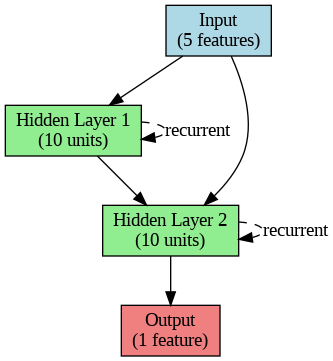

In [5]:
# Visualize RNN structure - Regular
print("Visualizing Regular RNN Structure...")
dot_regular = visualize_rnn_structure(input_size, hidden_size, num_layers, bidirectional=False)
dot_regular.render('rnn_structure_regular', format='png', cleanup=True)
from IPython.display import Image
Image('rnn_structure_regular.png')


Visualizing Bidirectional RNN Structure...


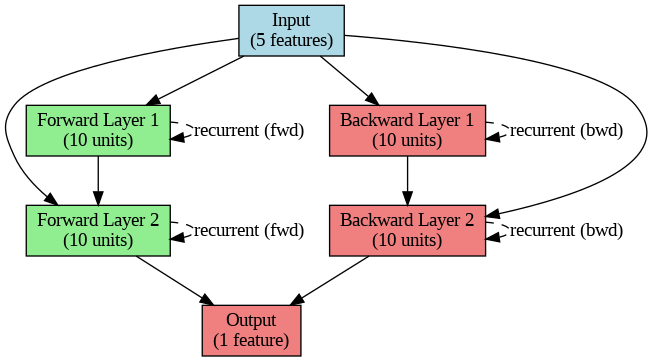

In [6]:
# Visualize RNN structure - Bidirectional
print("\nVisualizing Bidirectional RNN Structure...")
dot_bidirectional = visualize_rnn_structure(input_size, hidden_size, num_layers, bidirectional=True)
dot_bidirectional.render('rnn_structure_bidirectional', format='png', cleanup=True)
Image('rnn_structure_bidirectional.png')


Visualizing Bidirectional Processing...


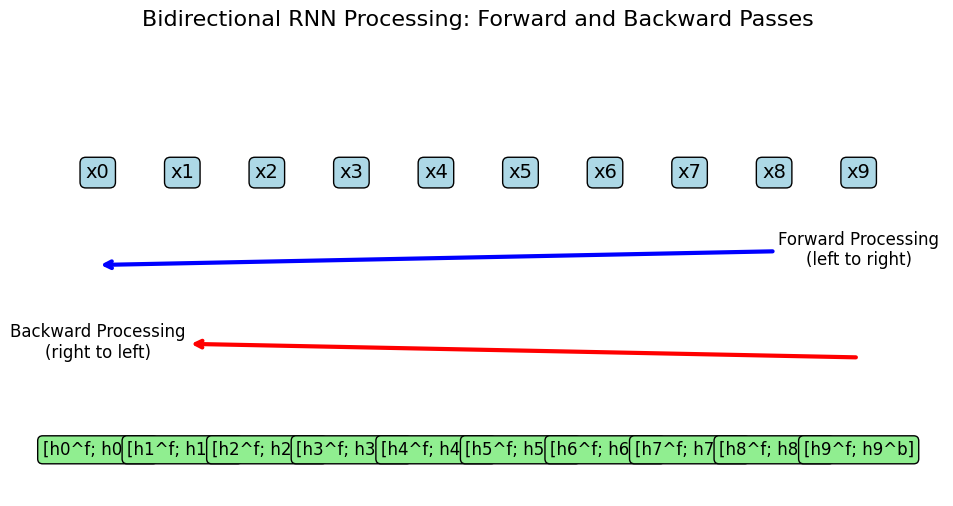

In [7]:
# Visualize bidirectional processing
print("\nVisualizing Bidirectional Processing...")
visualize_bidirectional_processing()


Regular RNN Mathematical Representation:


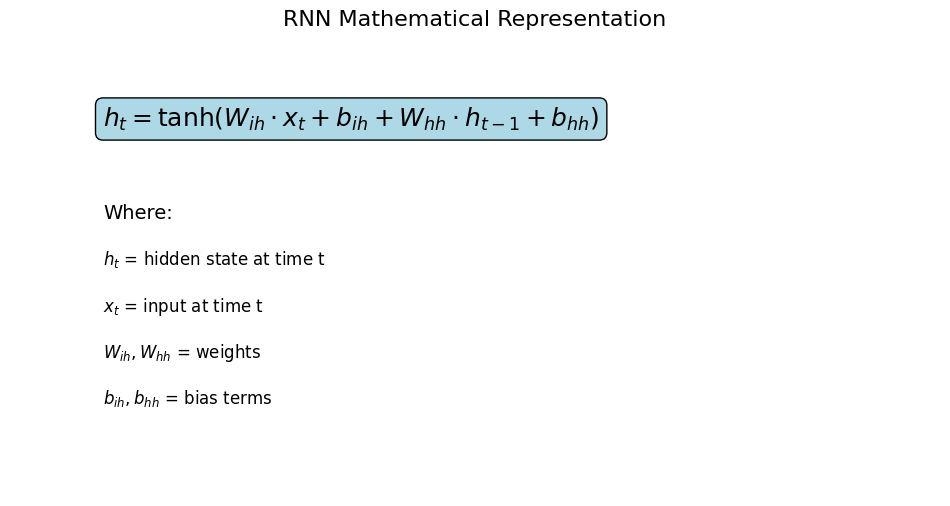

In [8]:
# Visualize RNN equations - Regular
print("\nRegular RNN Mathematical Representation:")
visualize_rnn_equations(bidirectional=False)


Bidirectional RNN Mathematical Representation:


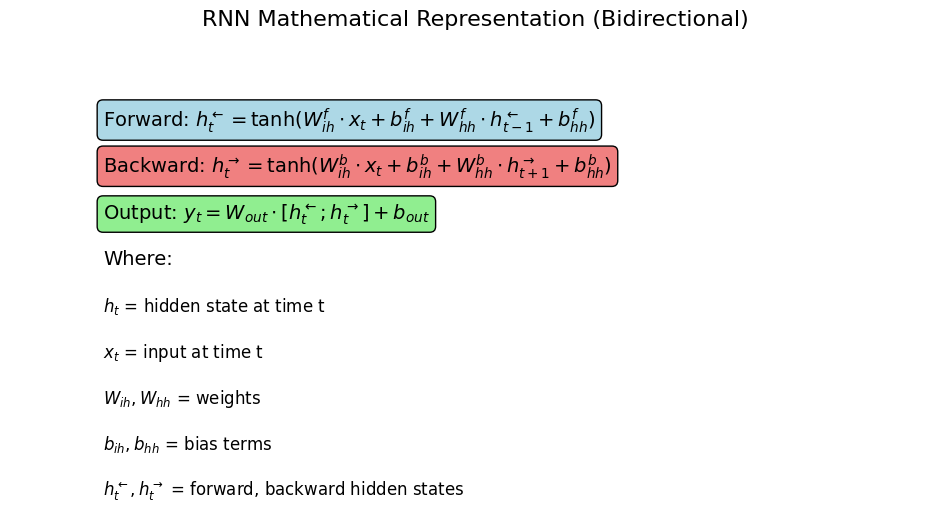

In [9]:

# Visualize RNN equations - Bidirectional
print("\nBidirectional RNN Mathematical Representation:")
visualize_rnn_equations(bidirectional=True)

In [14]:


# Create sample data for demonstration
def create_sample_data(seq_len=10, batch_size=1, input_size=5):
    # Create a simple pattern: input is a sequence of numbers
    # Output is the cumulative sum of the input sequence
    inputs = torch.randn(batch_size, seq_len, input_size)

    # Create target as cumulative sum of first input dimension
    targets = torch.cumsum(inputs[:, :, 0:1], dim=1)

    return inputs, targets

# Visualization function to plot train and test data
def plot_train_test_data(train_inputs, train_targets, test_inputs, test_targets):
    """
    Plot the training and testing data
    """
    # Concatenate train and test data along the batch dimension
    all_inputs = torch.cat([train_inputs, test_inputs], dim=0)  # Shape: (2, seq_len, input_size)
    all_targets = torch.cat([train_targets, test_targets], dim=0)  # Shape: (2, seq_len, 1)

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training input features over time
    im1 = axes[0, 0].imshow(train_inputs[0].T, aspect='auto', cmap='viridis')
    axes[0, 0].set_title('Training Input Features Over Time')
    axes[0, 0].set_xlabel('Time Step')
    axes[0, 0].set_ylabel('Input Feature')
    plt.colorbar(im1, ax=axes[0, 0])

    # Plot 2: Training targets over time
    axes[0, 1].plot(train_targets[0].flatten().numpy(), marker='o', label='Train Targets', color='blue')
    axes[0, 1].set_title('Training Targets Over Time')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Target Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot 3: Testing input features over time
    im2 = axes[1, 0].imshow(test_inputs[0].T, aspect='auto', cmap='viridis')
    axes[1, 0].set_title('Testing Input Features Over Time')
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Input Feature')
    plt.colorbar(im2, ax=axes[1, 0])

    # Plot 4: Testing targets over time
    axes[1, 1].plot(test_targets[0].flatten().numpy(), marker='s', label='Test Targets', color='red')
    axes[1, 1].set_title('Testing Targets Over Time')
    axes[1, 1].set_xlabel('Time Step')
    axes[1, 1].set_ylabel('Target Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()


Recurrent Neural Network (RNN) Demonstration
Model Parameters:
- Input size: 5
- Hidden size: 10
- Output size: 1
- Number of layers: 2
- Sequence length: 15

Regular RNN Model Architecture:
SimpleRNN(
  (rnn): RNN(5, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Bidirectional RNN Model Architecture:
BidirectionalRNN(
  (rnn): RNN(5, 10, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


Training Input shape: torch.Size([1, 15, 5])
Training Target shape: torch.Size([1, 15, 1])

Testing Input shape: torch.Size([1, 15, 5])
Testing Target shape: torch.Size([1, 15, 1])

Plotting Train and Test Data...


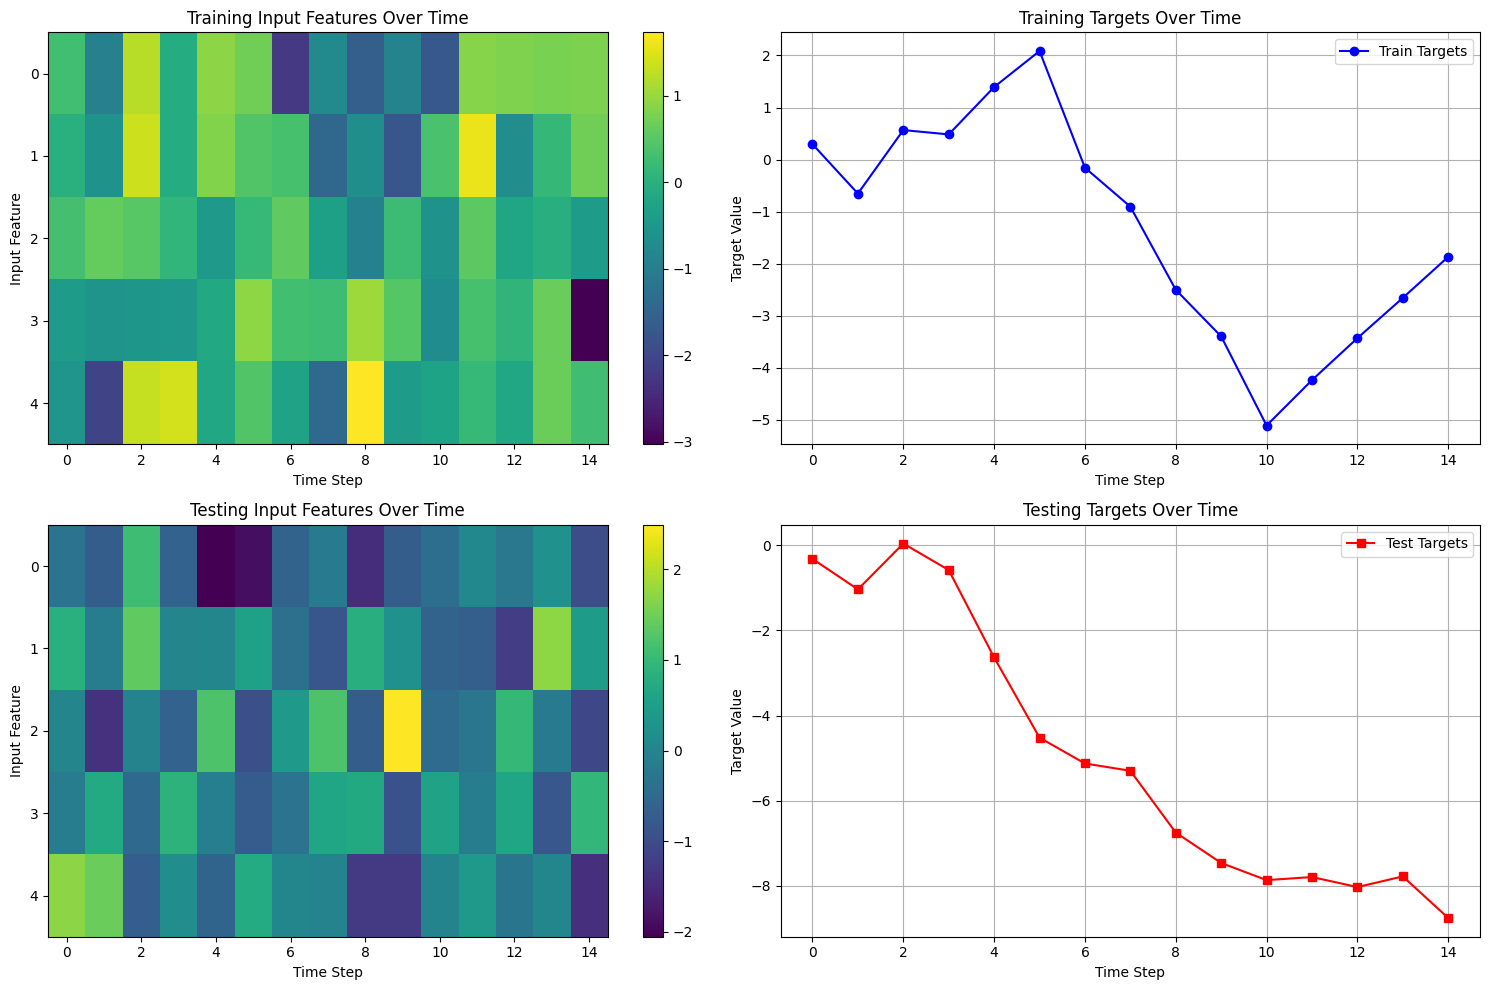


Input shape: torch.Size([1, 20, 5])
Target shape: torch.Size([1, 20, 1])

Training Regular RNN...
Regular RNN - Epoch [20/100], Loss: 10.9520
Regular RNN - Epoch [40/100], Loss: 9.6043
Regular RNN - Epoch [60/100], Loss: 8.9300
Regular RNN - Epoch [80/100], Loss: 5.7829
Regular RNN - Epoch [100/100], Loss: 1.8188

Training Bidirectional RNN...
Bidirectional RNN - Epoch [20/100], Loss: 9.1069
Bidirectional RNN - Epoch [40/100], Loss: 2.8038
Bidirectional RNN - Epoch [60/100], Loss: 0.2383
Bidirectional RNN - Epoch [80/100], Loss: 0.0381
Bidirectional RNN - Epoch [100/100], Loss: 0.0213

Regular RNN Final Loss: 1.7181
Bidirectional RNN Final Loss: 0.0209

Visualizing Regular RNN Training Progress...


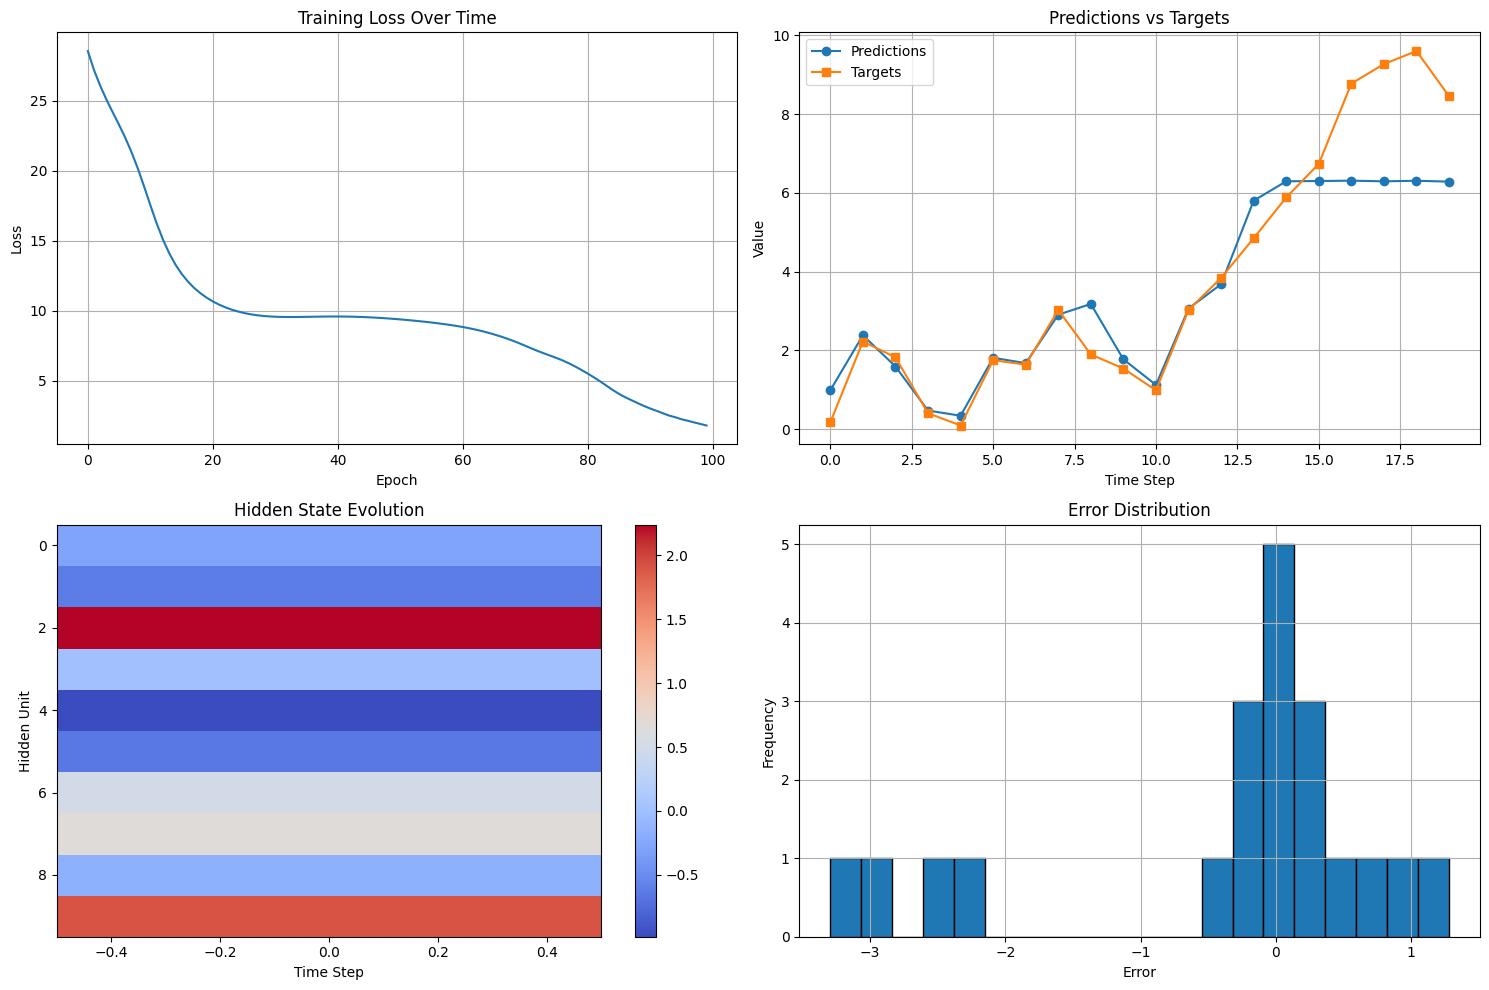


Visualizing Bidirectional RNN Training Progress...


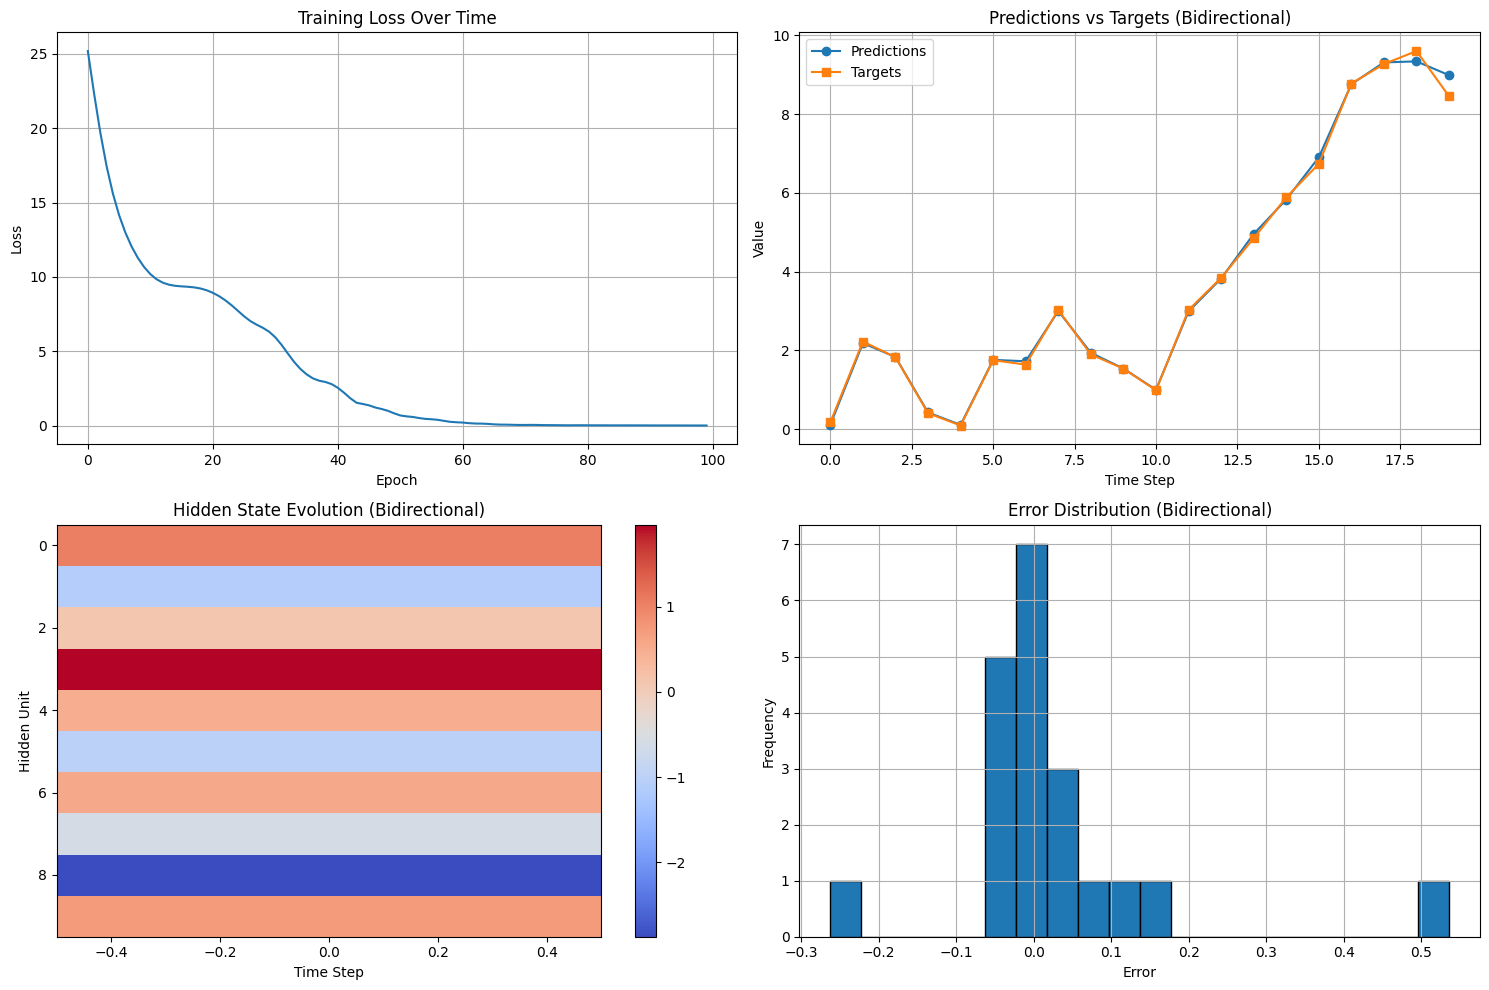

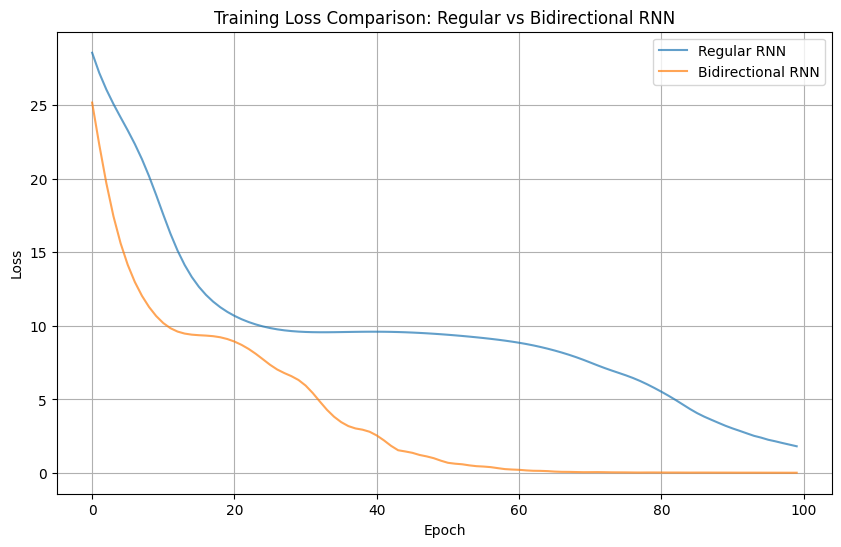


Visualizing Regular RNN Computations Over Time...


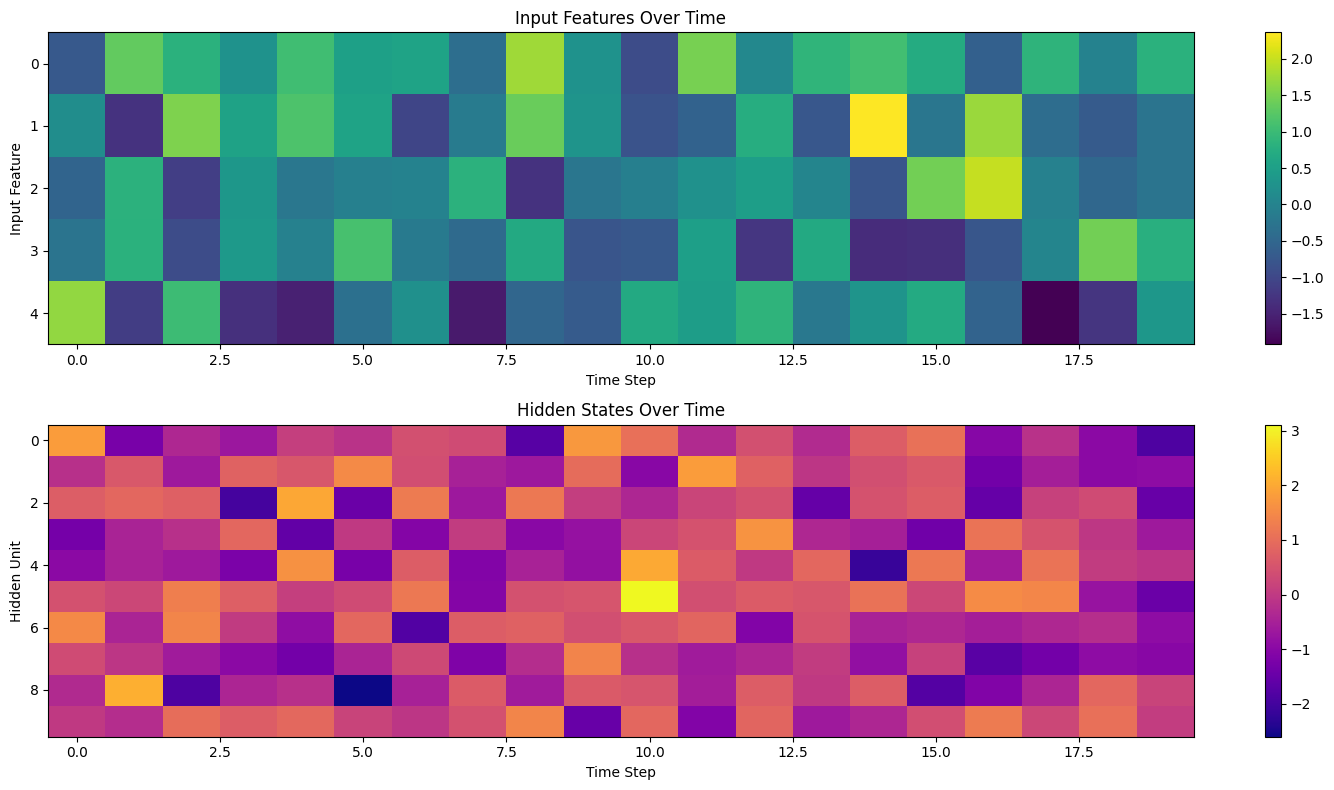


Visualizing Bidirectional RNN Computations Over Time...


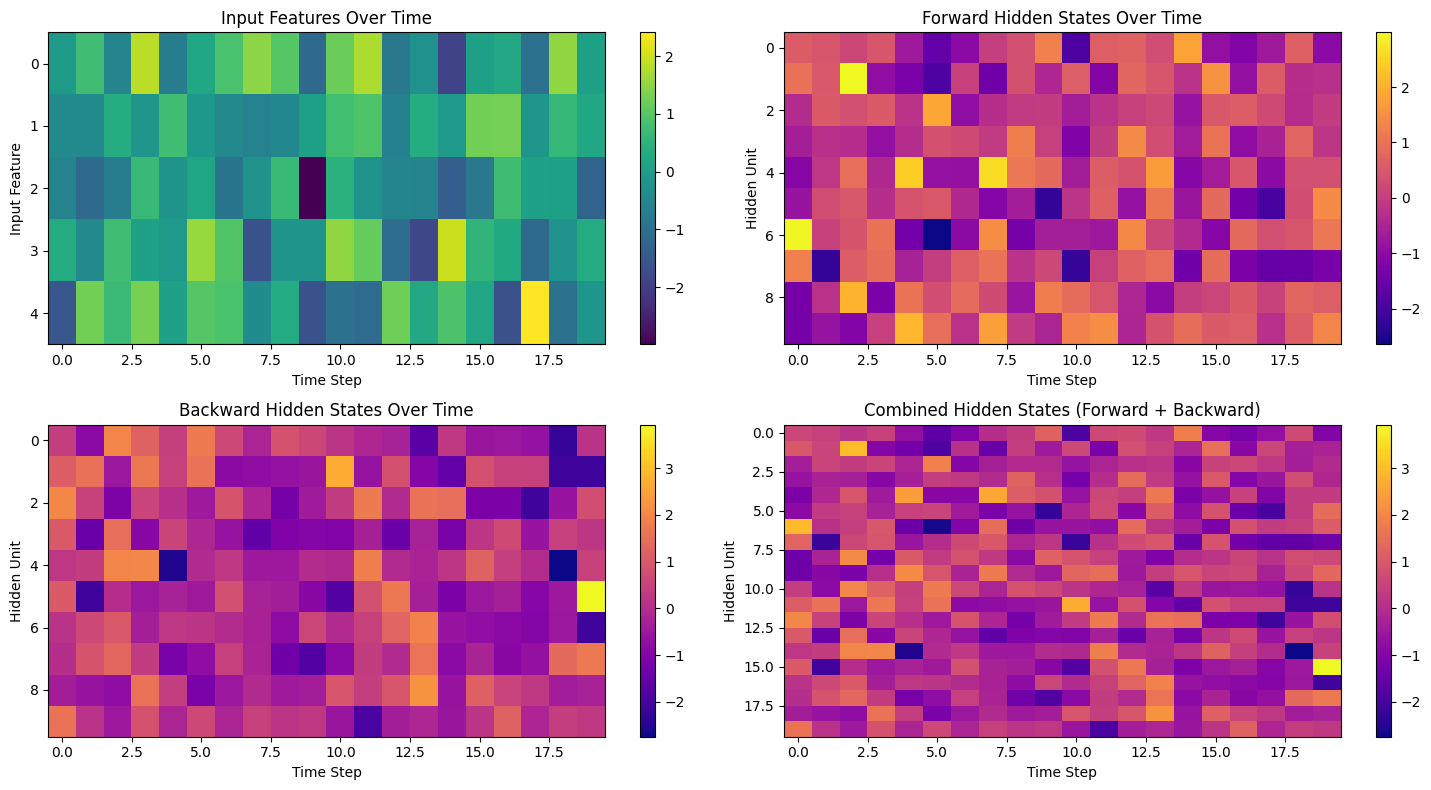


Visualizing Hidden State Evolution (Regular RNN)...


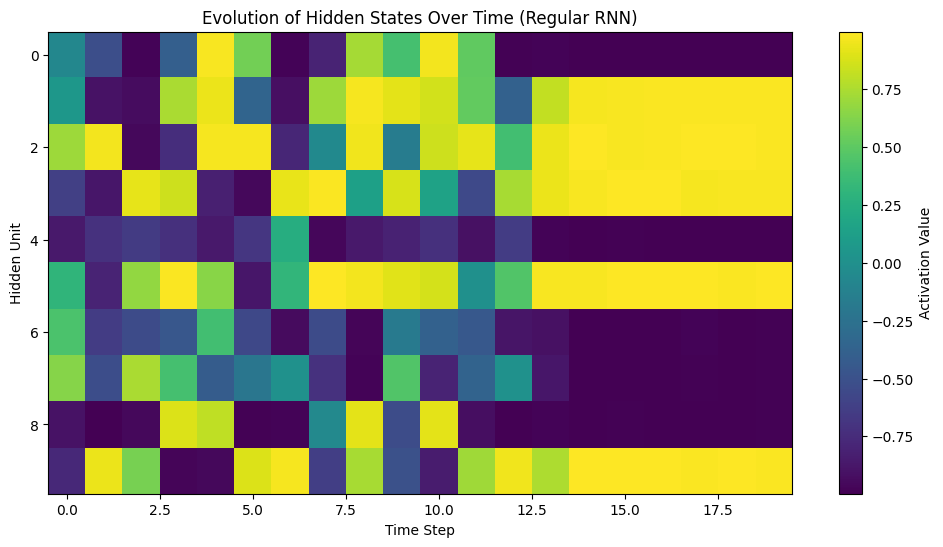


Visualizing Hidden State Evolution (Bidirectional RNN)...


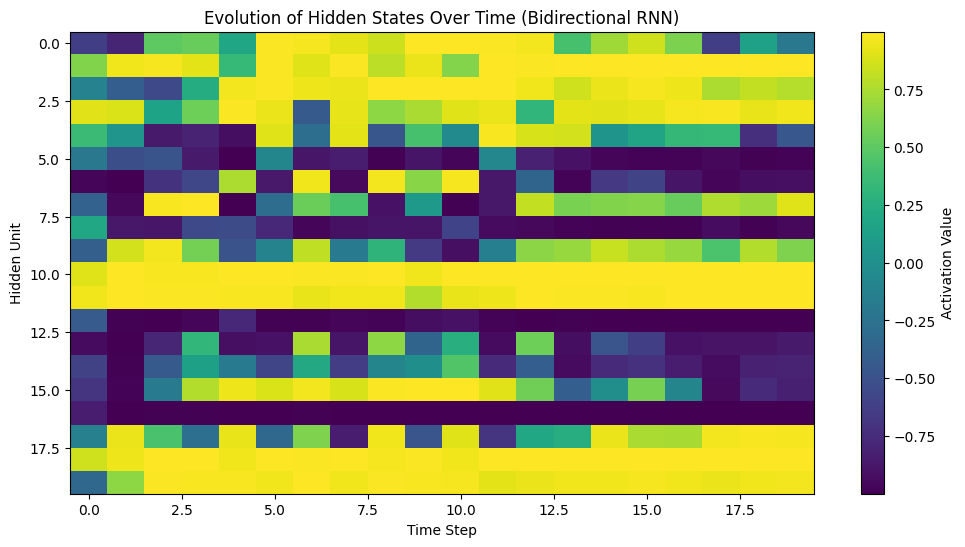


3D Visualization of Sequence Processing (Regular RNN)...



3D Visualization of Sequence Processing (Bidirectional RNN)...


In [15]:
# Main execution
print("Recurrent Neural Network (RNN) Demonstration")
print("="*50)

# Define model parameters
input_size = 5
hidden_size = 10
output_size = 1
num_layers = 2
seq_len = 15
batch_size = 1

print(f"Model Parameters:")
print(f"- Input size: {input_size}")
print(f"- Hidden size: {hidden_size}")
print(f"- Output size: {output_size}")
print(f"- Number of layers: {num_layers}")
print(f"- Sequence length: {seq_len}")
print()

# Create the models
model_regular = SimpleRNN(input_size, hidden_size, output_size, num_layers)
model_bidirectional = BidirectionalRNN(input_size, hidden_size, output_size, num_layers)

print("Regular RNN Model Architecture:")
print(model_regular)
print()

print("Bidirectional RNN Model Architecture:")
print(model_bidirectional)
print()

# Create sample data - training set
train_inputs, train_targets = create_sample_data(seq_len, batch_size, input_size)
print(f"\nTraining Input shape: {train_inputs.shape}")
print(f"Training Target shape: {train_targets.shape}")

# Create sample data - testing set
test_inputs, test_targets = create_sample_data(seq_len, batch_size, input_size)
print(f"\nTesting Input shape: {test_inputs.shape}")
print(f"Testing Target shape: {test_targets.shape}")

# Visualize train and test data
print("\nPlotting Train and Test Data...")
plot_train_test_data(train_inputs, train_targets, test_inputs, test_targets)

# Create sample data
seq_len = 20
inputs, targets = create_sample_data(seq_len, batch_size, input_size)
print(f"\nInput shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

# Training setup for regular RNN
print("\nTraining Regular RNN...")
criterion = nn.MSELoss()
optimizer_regular = torch.optim.Adam(model_regular.parameters(), lr=0.01)

# Training loop for regular RNN
num_epochs = 100
losses_regular = []

for epoch in range(num_epochs):
    optimizer_regular.zero_grad()

    # Forward pass
    outputs, hidden = model_regular(inputs)

    # Calculate loss
    loss = criterion(outputs, targets)
    losses_regular.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_regular.step()

    if (epoch + 1) % 20 == 0:
        print(f'Regular RNN - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Training setup for bidirectional RNN
print("\nTraining Bidirectional RNN...")
optimizer_bidirectional = torch.optim.Adam(model_bidirectional.parameters(), lr=0.01)

# Training loop for bidirectional RNN
losses_bidirectional = []

for epoch in range(num_epochs):
    optimizer_bidirectional.zero_grad()

    # Forward pass
    outputs, hidden = model_bidirectional(inputs)

    # Calculate loss
    loss = criterion(outputs, targets)
    losses_bidirectional.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer_bidirectional.step()

    if (epoch + 1) % 20 == 0:
        print(f'Bidirectional RNN - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Final predictions for regular RNN
with torch.no_grad():
    final_outputs_regular, _ = model_regular(inputs)
    final_loss_regular = criterion(final_outputs_regular, targets)
    print(f'\nRegular RNN Final Loss: {final_loss_regular.item():.4f}')

# Final predictions for bidirectional RNN
with torch.no_grad():
    final_outputs_bidirectional, _ = model_bidirectional(inputs)
    final_loss_bidirectional = criterion(final_outputs_bidirectional, targets)
    print(f'Bidirectional RNN Final Loss: {final_loss_bidirectional.item():.4f}')

# Visualize training progress for regular RNN
print("\nVisualizing Regular RNN Training Progress...")
plot_training_progress(losses_regular, final_outputs_regular, targets, bidirectional=False)

# Visualize training progress for bidirectional RNN
print("\nVisualizing Bidirectional RNN Training Progress...")
plot_training_progress(losses_bidirectional, final_outputs_bidirectional, targets, bidirectional=True)

# Compare losses
plt.figure(figsize=(10, 6))
plt.plot(losses_regular, label='Regular RNN', alpha=0.7)
plt.plot(losses_bidirectional, label='Bidirectional RNN', alpha=0.7)
plt.title('Training Loss Comparison: Regular vs Bidirectional RNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Visualize RNN computations over time - Regular
print("\nVisualizing Regular RNN Computations Over Time...")
visualize_rnn_computations_over_time(seq_len, input_size, hidden_size, bidirectional=False)

# Visualize RNN computations over time - Bidirectional
print("\nVisualizing Bidirectional RNN Computations Over Time...")
visualize_rnn_computations_over_time(seq_len, input_size, hidden_size, bidirectional=True)

# Visualize hidden state evolution during sequence processing
print("\nVisualizing Hidden State Evolution (Regular RNN)...")

# Process sequence step by step to see hidden state evolution
hidden_states_regular = []
with torch.no_grad():
    hidden = None
    for t in range(seq_len):
        input_t = inputs[:, t:t+1, :]  # Shape: (batch_size, 1, input_size)
        output_t, hidden = model_regular.rnn(input_t, hidden)
        hidden_states_regular.append(hidden[-1, 0, :].numpy())  # Take last layer, first batch

hidden_states_regular = np.array(hidden_states_regular)

# Plot hidden state evolution for regular RNN
plt.figure(figsize=(12, 6))
plt.imshow(hidden_states_regular.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.title('Evolution of Hidden States Over Time (Regular RNN)')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit')
plt.colorbar(label='Activation Value')
plt.show()

print("\nVisualizing Hidden State Evolution (Bidirectional RNN)...")

# Process sequence step by step to see hidden state evolution for bidirectional RNN
hidden_states_bidirectional = []
with torch.no_grad():
    hidden = None
    for t in range(seq_len):
        input_t = inputs[:, t:t+1, :]  # Shape: (batch_size, 1, input_size)
        output_t, hidden = model_bidirectional.rnn(input_t, hidden)
        # For bidirectional, we have forward and backward hidden states
        # We'll visualize the concatenated output
        hidden_states_bidirectional.append(output_t[0, 0, :].numpy())  # Take first batch, first time step

hidden_states_bidirectional = np.array(hidden_states_bidirectional)

# Plot hidden state evolution for bidirectional RNN
plt.figure(figsize=(12, 6))
plt.imshow(hidden_states_bidirectional.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.title('Evolution of Hidden States Over Time (Bidirectional RNN)')
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit')
plt.colorbar(label='Activation Value')
plt.show()

# Create a 3D visualization of the sequence
print("\n3D Visualization of Sequence Processing (Regular RNN)...")

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]],
    subplot_titles=['Regular RNN Sequence Processing']
)

# Create 3D plot of hidden states
time_steps = list(range(seq_len))
hidden_units = list(range(hidden_size))
time_mesh, unit_mesh = np.meshgrid(time_steps, hidden_units)

fig.add_trace(
    go.Scatter3d(
        x=time_mesh.flatten(),
        y=unit_mesh.flatten(),
        z=hidden_states_regular.T.flatten(),
        mode='markers',
        marker=dict(
            size=5,
            color=hidden_states_regular.T.flatten(),
            colorscale='Viridis',
            showscale=True
        ),
        name='Hidden States (Regular)'
    )
)

fig.update_layout(
    title='3D Visualization of Hidden State Evolution (Regular RNN)',
    scene=dict(
        xaxis_title='Time Step',
        yaxis_title='Hidden Unit',
        zaxis_title='Activation Value'
    ),
    width=800,
    height=600
)

fig.show()

# Create a 3D visualization of the sequence for bidirectional RNN
print("\n3D Visualization of Sequence Processing (Bidirectional RNN)...")

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{'type': 'scatter3d'}]],
    subplot_titles=['Bidirectional RNN Sequence Processing']
)

# Create 3D plot of hidden states
time_steps = list(range(seq_len))
hidden_units = list(range(hidden_size * 2))  # Double for forward and backward
time_mesh, unit_mesh = np.meshgrid(time_steps, hidden_units)

fig.add_trace(
    go.Scatter3d(
        x=time_mesh.flatten(),
        y=unit_mesh.flatten(),
        z=hidden_states_bidirectional.T.flatten(),
        mode='markers',
        marker=dict(
            size=5,
            color=hidden_states_bidirectional.T.flatten(),
            colorscale='Viridis',
            showscale=True
        ),
        name='Hidden States (Bidirectional)'
    )
)

fig.update_layout(
    title='3D Visualization of Hidden State Evolution (Bidirectional RNN)',
    scene=dict(
        xaxis_title='Time Step',
        yaxis_title='Hidden Unit',
        zaxis_title='Activation Value'
    ),
    width=800,
    height=600
)


